<a href="https://www.kaggle.com/code/fellahabdelnour13/diffusion-model-for-bitmoji-generation-inference?scriptVersionId=269448127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family:verdana;font-size:2.5rem;text-align:center;">
    Diffusion Model For Bitmoji Generation : Inference
</div>

<h1 style="font-family:verdana;">
    Overview
</h1>

- [Introduction](#intro)
- [Setup The Repo](#setup)
- [Necessary Packages](#necessary_packages)
- [Constants](#constants)
- [Load The Model](#load_the_model)
- [Generate Images](#generate_images)
- [Conclusion](#conclusion)

<div id="intro" >
    <h1 style="font-family:verdana;">Introduction</h1>
</div>

In this notebook i will showcase a project i worked on last year using this dataset to generate synthatic imagesusing Conditional Diffusion Model  training details are found <br/> in the [github repo](https://github.com/abdelnour13/images_generation_latent_diffusion_models).

<strong>Would like to know more about Diffusion Models ? Check out these YouTube Videos : </strong>

- [Why Does Diffusion Work Better than Auto-Regression?](https://www.youtube.com/watch?v=zc5NTeJbk-k)
- [Vector-Quantized Variational Autoencoders (VQ-VAEs) | Deep Learning](https://www.youtube.com/watch?v=yQvELPjmyn0)
- [Denoising Diffusion Probabilistic Models | DDPM Explained](https://www.youtube.com/watch?v=H45lF4sUgiE&t=1581s)
- [Stable Diffusion from Scratch in PyTorch | Unconditional Latent Diffusion Models](https://www.youtube.com/watch?v=1BkzNb3ejK4)
- [Stable Diffusion from Scratch in PyTorch | Conditional Latent Diffusion Models](https://www.youtube.com/watch?v=hEJjg7VUA8g&t=1178s)

<div id="setup" >
    <h1 style="font-family:verdana;">Setup The Repo</h1>
</div>

In [1]:
!git clone https://github.com/abdelnour13/images_generation_latent_diffusion_models

Cloning into 'images_generation_latent_diffusion_models'...
remote: Enumerating objects: 571, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 571 (delta 33), reused 53 (delta 18), pack-reused 493 (from 2)
Receiving objects: 100% (571/571), 302.28 MiB | 42.89 MiB/s, done.
Resolving deltas: 100% (228/228), done.
Updating files: 100% (73/73), done.


In [2]:
%cd /kaggle/working/images_generation_latent_diffusion_models
!ls

/kaggle/working/images_generation_latent_diffusion_models
create.py  definitions.py  download.py	notebooks  requirements.txt
data	   demo		   experiments	README.md  src


<div id="necessary_packages">
    <h1 style="font-family:verdana;">Necessary Packages</h1>
</div>

In [3]:
import sys
import torch
import os
import pandas as pd
import numpy as np
sys.path.append('../..')
import torch
import definitions as D
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

In [4]:
!pip install get_my_palette_from_image==0.1.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 90.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.1

In [5]:
from src.models import LatentDiffusion
from src.training.diffusion import Config,create_dataloaders
from IPython import display
from src.utils import get_last_checkpoint,load_json,make_grid,seed_everything

2025-10-20 14:53:20.815371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760972001.007358      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760972001.060766      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import seaborn as sns

In [7]:
SEED = 42
seed_everything(SEED)

<div id="constants" >
    <h1 style="font-family:verdana;">Constants</h1>
</div>

In [8]:
MODEL_DIR = "/kaggle/input/diffusion_models/pytorch/bitmojie_trained/1"
DIFF_CHECKPOINT_PATH = os.path.join(MODEL_DIR, "checkpoint_diff_cond.pth")

<div id="load_the_model" >
    <h1 style="font-family:verdana;">Load The Model</h1>
</div>

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EXPIREMENT = 'diffusion_bitmojie_cond'
CONFIG_PATH = os.path.join(D.EXPERIMENTS_DIR,EXPIREMENT,'config.json')
config = Config(**load_json(CONFIG_PATH))

In [10]:
diff_checkpoint = torch.load(DIFF_CHECKPOINT_PATH, map_location = DEVICE)
model = LatentDiffusion(config.model_config).to(DEVICE).eval()
model.load_state_dict(diff_checkpoint)

<All keys matched successfully>

<div id="generate_images" >
    <h1 style="font-family:verdana;">Generate Images</h1>
</div>

- Unconditional

In [11]:
noise = torch.randn(16, 3, 16, 16).to(DEVICE)
_,images = model.generate(noise, decode_every=20,progress=True,device="cpu")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
grid = make_grid(images[-1],4,4,4,1.0)
plt.imshow(grid)

- Conditional : Using A Color Palette

In [13]:
palette = np.array([
    [0, 0, 0],
    [107, 73, 15],
    [14, 13, 11],
    [86, 103, 131],
    [163, 122, 38],
    [188, 188, 190],
    [246, 187, 151],
    [58, 41, 24],
    [95, 79, 71],
    [171, 136, 115]
]) / 255.0

sns.palplot(palette)

In [14]:
palette = torch.from_numpy(palette).float().unsqueeze(0).repeat(16,1,1).to(DEVICE)
_,images = model.generate(noise,color_palette=palette,decode_every=20,progress=True,device="cpu")

  0%|          | 0/1000 [00:00<?, ?it/s]

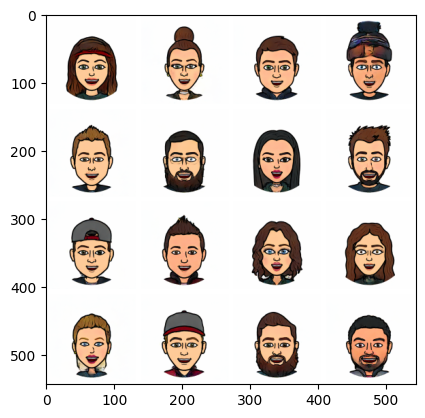

In [15]:
grid = make_grid(images[-1],4,4,4,1.0)
plt.imshow(grid)

- Visualize the generation process

In [16]:
grid = make_grid(images,4,4,4,1.0)
grid = 255 * grid
grid = grid.type(torch.uint8)

In [17]:
frames = list(grid.numpy())

In [18]:
gif_path = os.path.join(D.EXPERIMENTS_DIR,EXPIREMENT,'generation_process.gif')

In [19]:
imageio.mimsave(gif_path,frames)

In [20]:
Image(open(gif_path, 'rb').read())

<div id="conclusion" >
    <h1 style="font-family:verdana;">Thank You :)</h1>
</div>